In [ ]:
import os 
os.chdir('/home')

#

# Setup

Upload Train.csv from Zindi and we should be good to go :)

In [ ]:
!pip install --upgrade fastcore -q
!pip install --upgrade fastai -q

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 194kB 3.1MB/s 


In [ ]:
import fastai
import torch


In [ ]:
from fastai import * # Needs latest version, and sometimes a restart of the runtime after the pip installs

# Loading the Crash Data

In [ ]:
import pandas as pd 

In [ ]:
cs = pd.read_csv('Train.csv')
cs.head()


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


# Finding locations with Gradient Descent

To do the gradient descent we'll rely on PyTorch to calculate gradients. If you're not familiar with tensors and this part looks scary, check out the fastai lossons that cover SGD from scratch (Lessons 3 and 4 of the new course and this book chapter:https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb). This is where I got a lot of the inspiration for this code.

I start with 6 random locations that are close to the center of the crashes - plot these over the crashes and see if this initialization seems sensible.

In [ ]:
# Ambulance Locations
amb_locs = torch.randn(6, 2) * 0.04545# 6 pairs of random numbers, made fairly small
amb_locs = amb_locs + torch.tensor([-1.2721, 36.851]) # Centered around the middle of town
amb_locs.requires_grad_() # Tell pytorch to calculate gradients
initial_locs = amb_locs.clone() # Save originals for later
amb_locs # View our set of initial locations

tensor([[-1.2468, 36.8468],
        [-1.2740, 36.9218],
        [-1.3368, 36.8828],
        [-1.2773, 36.8224],
        [-1.3073, 36.8314],
        [-1.2663, 36.8293]], requires_grad=True)

In [ ]:
# Crash locations - turn the training data into a tensor we can work with
crash_locs = torch.tensor(cs[['latitude', 'longitude']].values) # To Tensor

Now we specify our loss function. This needs to preserve gradients, which it does.

In [ ]:
def loss_fn(crash_locs, amb_locs):
  """For each crash we find the dist to the closest ambulance, and return the mean of these dists."""
  # Dists to first ambulance
  dists_split = crash_locs-amb_locs[0]
  dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
  min_dists = dists
  for i in range(1, 6):
    # Update dists so they represent the dist to the closest ambulance
    dists_split = crash_locs-amb_locs[i]
    dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
    min_dists = torch.min(min_dists, dists)
  
  return min_dists.mean()

In [ ]:
# Calculate loss:
loss = loss_fn(crash_locs, amb_locs)
loss

tensor(0.0810, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
# We can use .backward to find gradients
loss.backward()

In [ ]:
# View gradients - they've been calculated for us!!!
amb_locs.grad

tensor([[-3.6017e-03,  1.8127e-03],
        [-5.6819e-06,  1.6174e-04],
        [-6.2368e-03, -1.1411e-02],
        [-5.0244e-06,  1.8488e-04],
        [ 5.9070e-06,  1.7922e-04],
        [-5.6481e-06,  1.0050e-04]])

These gradients tell us which way to move the locations to reduce the loss. This is all we need to do some gradient descent! We'll pick a learning rate, and then run through 2100 steps, updating the locations each time:

In [ ]:
amb_locs.grad = None # Reset gradients
lr=0.0055567 # Pick LR
for i in range(2100):
  loss = loss_fn(crash_locs, amb_locs) # Find loss
  if i % 100 == 0: print('Loss:', loss.item()) # Print loss
  loss.backward() # Calc grads
  amb_locs.data -= lr * amb_locs.grad.data # Update locs
  amb_locs.grad = None # Reset gradients for next step

Loss: 0.07575635202326234
Loss: 0.05886522488742945
Loss: 0.056283304492870986
Loss: 0.05607907020169987
Loss: 0.055746526947674
Loss: 0.05549876575784375
Loss: 0.054619579212486516
Loss: 0.053865732217287104
Loss: 0.053501785890046116
Loss: 0.05308961038976011
Loss: 0.052773890261112164
Loss: 0.05234878707939372
Loss: 0.05213440155347485
Loss: 0.05210870572964199
Loss: 0.05210606150172934
Loss: 0.05210436387678115
Loss: 0.05210281166225282
Loss: 0.05210179009166836
Loss: 0.05210090706641769
Loss: 0.05210004773878483
Loss: 0.05209941366569412


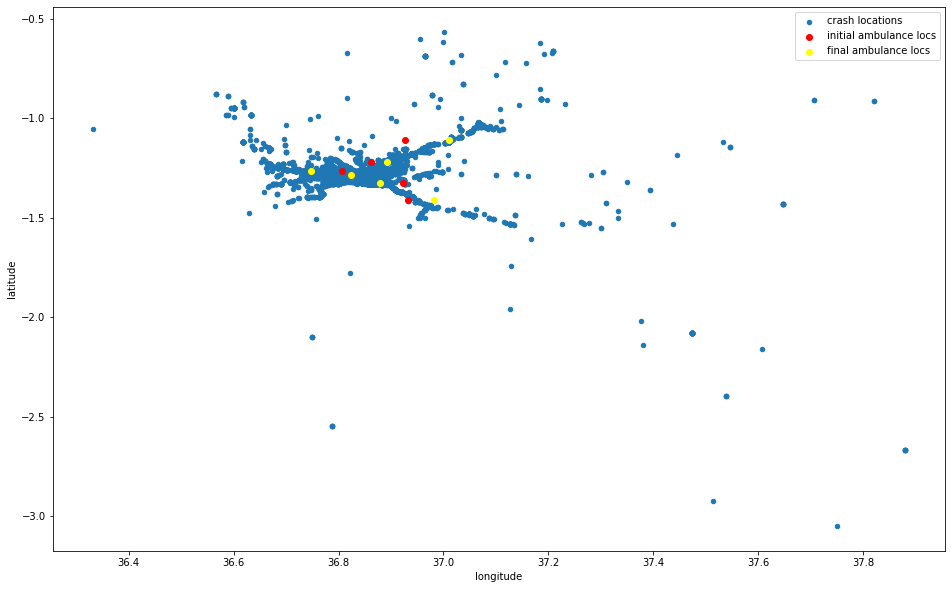

In [ ]:
# Plot crashes and ambulance locations
ax = cs.plot(y='latitude', x='longitude', kind='scatter', figsize=(16, 10), label='crash locations')
ax.scatter(initial_locs[:,1].detach().numpy(), amb_locs[:,0].detach().numpy(), c='red', label='initial ambulance locs')
ax.scatter(amb_locs[:,1].detach().numpy(), amb_locs[:,0].detach().numpy(), c='yellow', label='final ambulance locs')
ax.legend()

# Stochastic Gradient Descent and a Validation Set

We can train with mini-batches (SGD) to speed things up. We'll also use the last 1000 crashes as a validation set and track how well we do on that over time. 

In [ ]:
crash_locs

tensor([[-1.1888, 36.9314],
        [-1.2881, 36.8266],
        [-1.1888, 36.9314],
        ...,
        [-1.3221, 36.8252],
        [-1.2786, 36.8165],
        [-1.2115, 36.9076]], dtype=torch.float64)

In [ ]:
# Split for validation
train_locs = crash_locs[:-1000]
val_locs = crash_locs[-1000:]

# Load crash locs from train into a dataloader
dl = torch.utils.data.DataLoader(train_locs, batch_size=100, shuffle=True)

# Set up ambulance locations
amb_locs = torch.randn(6, 2) * 0.04
amb_locs = amb_locs + torch.tensor([-1.27, 36.85])
amb_locs.requires_grad_()

# Set vars
lr=2e-3
n_epochs = 30

# Store loss over time
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
   # Run through batches
  for crashes in dl:
    loss = loss_fn(crashes, amb_locs) # Find loss for this batch of crashes
    loss.backward() # Calc grads
    amb_locs.data -= lr * amb_locs.grad.data # Update locs
    amb_locs.grad = None # Reset gradients for next step
    train_losses.append(loss.item())
    val_losses.append(loss_fn(val_locs, amb_locs).item()) # Can remove as this lows things down

  # Print validation loss
  print('Val loss:', loss_fn(val_locs, amb_locs).item())

Val loss: 0.07290853432184997
Val loss: 0.06973532938109966
Val loss: 0.06792754006632587
Val loss: 0.06612602485843294
Val loss: 0.06462004650628612
Val loss: 0.0636440826423305
Val loss: 0.06319296531742677
Val loss: 0.06298205263927549
Val loss: 0.06285699985972466
Val loss: 0.06278828711528348
Val loss: 0.06271757260556278
Val loss: 0.06257699912893497
Val loss: 0.06237236950779082
Val loss: 0.06217299867853788
Val loss: 0.062000118374815914
Val loss: 0.061852113434250296
Val loss: 0.06176268760882538
Val loss: 0.0617284048780902
Val loss: 0.061704801128731376
Val loss: 0.06168403068374841
Val loss: 0.061659920714492215
Val loss: 0.06164812909481799
Val loss: 0.06163631389061083
Val loss: 0.06161315580624023
Val loss: 0.06159514520907619
Val loss: 0.06155961442531575
Val loss: 0.06155681870824631
Val loss: 0.06155579981862718
Val loss: 0.06153358434198815
Val loss: 0.061510153113434635


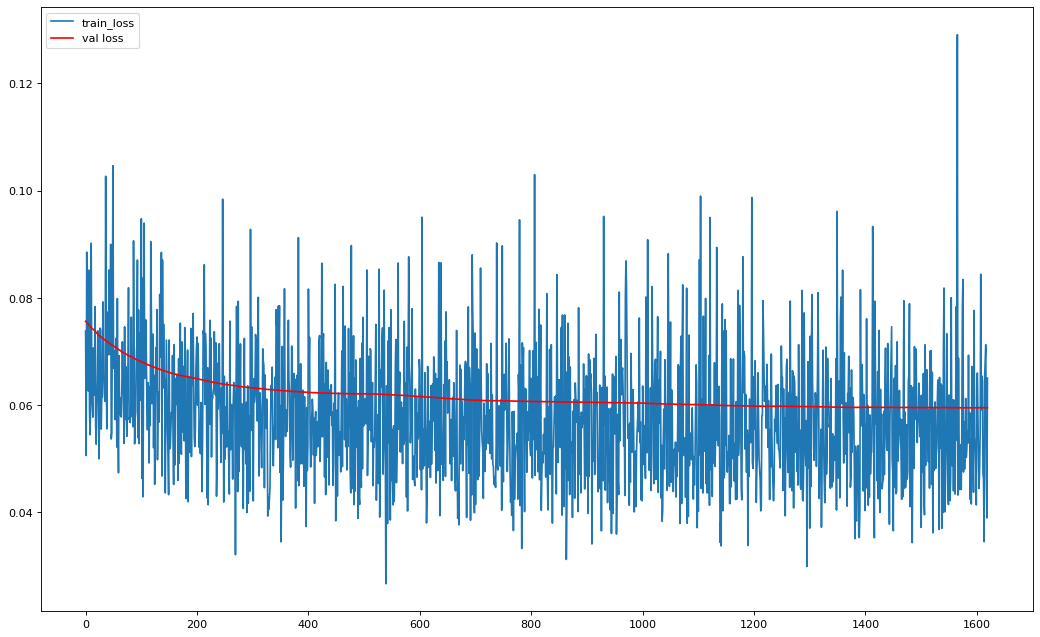

In [ ]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, c='red', label='val loss')
plt.legend()

In [ ]:
cs = pd.read_csv('Train.csv')
# Clipping to the central area for a better view
cs = cs.loc[(cs.latitude < -1.375+0.2)&(cs.latitude > -1.375)\
            &(cs.longitude > 36.6)&(cs.longitude < 36.6+0.45)]
crash_locs = torch.tensor(cs[['latitude', 'longitude']].values) # To Tensor

In [ ]:
locs = []
# Ambulance Locations
amb_locs = torch.randn(6, 2) * 0.045
amb_locs = amb_locs + torch.tensor([-1.271, 36.851])
amb_locs.requires_grad_()
locs.append(amb_locs.detach().numpy()) # Store

In [ ]:
amb_locs[:,1].detach().numpy(), amb_locs[:,0].detach().numpy()

(array([36.881268, 37.05725 , 36.74537 , 36.86727 , 36.820114, 36.956516],
       dtype=float32),
 array([-1.3286372, -1.491225 , -1.2637322, -1.2441365, -1.288891 ,
        -1.1628844], dtype=float32))

In [ ]:
def score_ambulance(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [ ]:
# Example:

# Test set
reference = cs.loc[cs.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

In [ ]:
sgd_centres_3=pd.DataFrame(amb_locs.detach().numpy(),columns=['lat','long'])

In [ ]:
sgd_centres_3=pd.DataFrame(amb_locs.detach().numpy(),columns=['lat','long'])
# Create submission dataframe
submission = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    submission['A'+str(ambulance)+'_Latitude'] = sgd_centres_3.iloc[ambulance][0]
    submission['A'+str(ambulance)+'_Longitude'] = sgd_centres_3.iloc[ambulance][1]
submission.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.219074,36.891781,-1.112684,37.009583,-1.40318,36.946991,-1.264319,36.746819,-1.325448,36.872391,-1.284332,36.823162
1,2019-01-01 03:00:00,-1.219074,36.891781,-1.112684,37.009583,-1.40318,36.946991,-1.264319,36.746819,-1.325448,36.872391,-1.284332,36.823162
2,2019-01-01 06:00:00,-1.219074,36.891781,-1.112684,37.009583,-1.40318,36.946991,-1.264319,36.746819,-1.325448,36.872391,-1.284332,36.823162
3,2019-01-01 09:00:00,-1.219074,36.891781,-1.112684,37.009583,-1.40318,36.946991,-1.264319,36.746819,-1.325448,36.872391,-1.284332,36.823162
4,2019-01-01 12:00:00,-1.219074,36.891781,-1.112684,37.009583,-1.40318,36.946991,-1.264319,36.746819,-1.325448,36.872391,-1.284332,36.823162


In [ ]:
score_ambulance(submission, reference)

92.34788837961041

In [ ]:
submission.to_csv('submission_40.csv',index=False)